In [8]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset


    

In [9]:
# Dataset Paths
train_data_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_data_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract features and labels for SMOTE
def extract_features(generator):
    features, labels = [], []
    for images, lbls in generator:
        features.append(images.reshape(images.shape[0], -1))  # Flatten images
        labels.append(np.argmax(lbls, axis=1))
        if len(features) * generator.batch_size >= generator.samples:
            break
    return np.vstack(features), np.hstack(labels)

x_train, y_train = extract_features(train_generator)
x_val, y_val = extract_features(val_generator)

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Convert labels back to categorical
num_classes = train_generator.num_classes
y_train_resampled = keras.utils.to_categorical(y_train_resampled, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Define categories
categories = list(train_generator.class_indices.keys())

Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.


In [10]:
# Load Pretrained DenseNet Model
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in densenet_base.layers:
    layer.trainable = False  # Freeze base model layers

# Custom Classification Head
x = GlobalAveragePooling2D()(densenet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=densenet_base.input, outputs=output_layer)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,565,895 (28.86 MB)

 Trainable params: 528,391 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
# Compile Model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train Model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train_resampled) // 32,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

# Evaluate Model
y_true = []
y_pred = []
for images, labels in val_generator:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= val_generator.samples:
        break
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/28 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0755 - loss: 3.2143 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.0803 - loss: 3.1382 - val_accuracy: 0.1838 - val_loss: 2.0781
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1830 - loss: 2.4018 - val_accuracy: 0.2647 - val_loss: 2.0054
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2340 - loss: 2.1019 - val_accuracy: 0.3456 - val_loss: 1.8316
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 719ms/step - accuracy: 0.3041 - loss: 2.0002 - val_accuracy: 0.3971 - val_loss: 1.6805
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2565 - loss: 2.0287 - val_accuracy: 0.4485 - val_loss: 1.6712
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - accuracy: 0.3948 - loss: 1.7365 - val_accuracy: 0.4191 - val_loss: 1.6106
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 997ms/step - accuracy: 0.3727 - loss: 1.7372 - val_accuracy: 0.4338 - val_loss: 1.5209
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4553 - loss: 1.5208 - val_accuracy: 0.4853 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


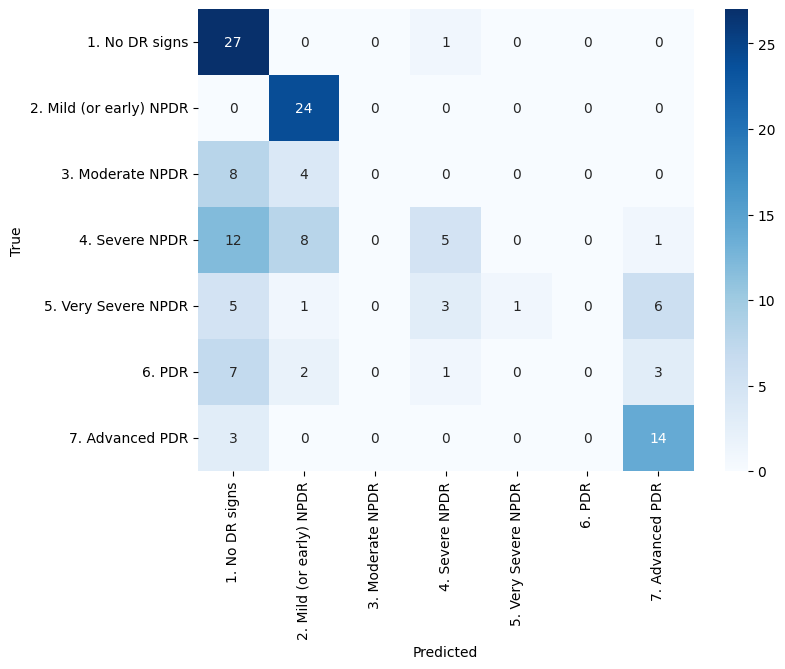

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Custom Metrics Calculation
def calculate_metrics(cm):
    TN = np.diag(cm).sum() - np.diag(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    
    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    specificity = TN / (TN + FP + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return {
        "Precision": np.mean(precision),
        "Recall (Sensitivity)": np.mean(recall),
        "Specificity": np.mean(specificity),
        "F1 Score": np.mean(f1_score)
    }


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

# Contrastive loss with temperature scaling
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        # Normalize embeddings
        z1 = nn.functional.normalize(z1, p=2, dim=-1)
        z2 = nn.functional.normalize(z2, p=2, dim=-1)

        # Cosine similarity matrix
        similarity = torch.matmul(z1, z2.T) / self.temperature
        labels = torch.arange(similarity.size(0), device=z1.device)

        # Cross-entropy loss
        loss = nn.CrossEntropyLoss()(similarity, labels)
        return loss

# DenseNet-based embedding model
class DenseNetEmbeddingModel(nn.Module):
    def __init__(self, base_model='densenet121'):
        super(DenseNetEmbeddingModel, self).__init__()
        backbone = getattr(models, base_model)(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = backbone.features
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.embedding = nn.Linear(backbone.classifier.in_features, 512)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x).view(x.size(0), -1)
        x = self.embedding(x)
        return x

# Data augmentation for contrastive learning
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset for contrastive pairs
class ContrastiveLearningDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2, label

    def __len__(self):
        return len(self.dataset)

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=T.ToTensor())
contrastive_dataset = ContrastiveLearningDataset(train_dataset, transform)
train_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=4)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetEmbeddingModel().to(device)
criterion = ContrastiveLoss(temperature=0.07)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for img1, img2, _ in train_loader:
        img1, img2 = img1.to(device), img2.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast():
            z1 = model(img1)
            z2 = model(img2)
            loss = criterion(z1, z2)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

print("Training complete.")


Files already downloaded and verified


<ipython-input-13-7354554feec4>:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-13-7354554feec4>", line 59, in __getitem__
    img1 = self.transform(img)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>
